In [4]:
"""ignoring new stations for now, just to check feasibility"""

using JuMP
using Gurobi

# define model:
model = Model(Gurobi.Optimizer)

# define parameters (TODO: placeholders for illustration):
S = 1:2       # scenarios
M = 1:5                 # all stations
N = [2]              # new station candidates (subset of M)
E = [
    (1,2), (2,1),
    (2,3), (3,2),
    (3,4), (4,3),
    (3,5), (5,3)
]
L = 1:2      # lines
K = 1:3      # trains
# initialize all B to 0
B = Dict((l,i,j) => 0 for l in L, i in M, j in M)

# ----- Line 1 edges -----
for (i, j) in [(1,2), (2,3), (3,4)]
    B[(1, i, j)] = 1
    B[(1, j, i)] = 1   # make symmetric
end

# ----- Line 2 edges -----
for (i, j) in [(3,5)]
    B[(2, i, j)] = 1
    B[(2, j, i)] = 1
end

T = 4
C = 100

A1 = Dict((s,i) => 0.0 for s in S, i in M)
A2 = Dict((s,i) => 0.0 for s in S, i in M)

I = Dict((s,i) => 10.0 for s in S, i in M)
O = Dict((s,i) => 10.0 for s in S, i in M)

R1 = Dict((s,i,n) => 0.0 for s in S, i in M, n in N)
R2 = Dict((s,i,n) => 0.0 for s in S, i in M, n in N)
D = Dict((s,o,d)=>10.0 for s in S, o in M, d in M if o != d)
deltaD = Dict((s,o,d,n)=>0.0 for s in S, o in M, d in M, n in N if o != d)



# define the B[l,i,j] matrix manually for testing. it is just a 3D matrix
# TODO: complete this


# define decision variables:
# @variable(model, x[i in N], Bin)
@variable(model, x[i in N] == 0) # TODO: this is temp. remove later

# @variable(model, v[s in S, l in L, k in K, (i, j) in E] >= 0) # v_s,l,k,i,j: Line l passengers on train k over edge (i,j)
@variable(model, v[s in S, l in L, k in K, (i,j) in E, o in M, d in M] >= 0)

@variable(model, V[s in S, l in L, k in K], Bin)
# TODO: below are simplified passenger entries and exits, need to update to account for varying per new station locations
@variable(model, e[s in S, (i, j) in E] >= 0) # e_s,i,j: Total passenger flow over edge (i,j)
# @variable(model, z >= 0) # z: Maximum crowding measure  


# define constraints:
@constraint(model, train_limit[s in S],
    sum(V[s, l, k] for l in L, k in K) <= T
)
@constraint(model, train_unique[s in S, k in K],
    sum(V[s, l, k] for l in L) <= 1
)
# @constraint(model, v_constraint[s in S, l in L, k in K, (i, j) in E],
#     v[s, l, k, (i, j)] <= C * V[s, l, k]
# )
@constraint(model, v_constraint[s in S, l in L, k in K, (i, j) in E],
    sum(v[s, l, k, (i,j), o, d] for o in M, d in M) <= C * V[s, l, k]
)



@constraint(model, edge_flow_def[s in S, (i, j) in E],
    e[s, (i, j)] == sum(B[l, i, j] * v[s, l, k, (i, j), o, d] for l in L, k in K, o in M, d in M)
)
for s in S, l in L, k in K, (i,j) in E, o in M, d in M
    if i == d || j == o
        @constraint(model, v[s,l,k,(i,j),o,d] == 0)
    end
end


# @variable(model, x[i in N], Bin)  # station build decisions

# D_s_o_d is the base OD demand
# deltaD_s_o_d_n is the increase in OD demand if station n is built
# Outgoing flow per station
# Outgoing flow per station
# Outgoing flow per station
# Outgoing flow per station
for s in S, o in M
    @constraint(model,
        sum(
            v[s, l, k, (i,j), o, d]  # ✓ CORRECT
            for l in L, k in K, (i,j) in E, d in M
            if i == o && d != o
        ) ==
        sum(D[s,o,d] + sum(deltaD[s,o,d,n]*x[n] for n in N) for d in M if d != o)
    )
end

# Incoming flow per station
for s in S, d in M
    @constraint(model,
        sum(
            v[s, l, k, (i,j), o, d]  # ✓ CORRECT
            for l in L, k in K, (i,j) in E, o in M
            if j == d && o != d
        ) ==
        sum(D[s,o,d] + sum(deltaD[s,o,d,n]*x[n] for n in N) for o in M if o != d)
    )
end




# linearize objective to min crowding:

# want to min max crowding on any given line:
@variable(model, z >= 0) # z: Maximum crowding measure
# @constraint(model, crowding_linearization[s in S, l in L, k in K, (i, j) in E],
#     C * z >= v[s, l, k, (i, j)]
# )
@constraint(model, crowding_linearization[s in S, l in L, k in K, (i, j) in E],
    C * z >= sum(v[s, l, k, (i,j), o, d] for o in M, d in M)
)

# define objective:
@objective(model, Min, z)

optimize!(model)

println("Termination status: ", termination_status(model))
println("Objective value: ", objective_value(model))
println("Train assignments V:")
for s in S, l in L, k in K
    println("V[$s,$l,$k] = ", value(V[s,l,k]))
end



Set parameter Username
Set parameter LicenseID to value 2751185
Academic license - for non-commercial use only - expires 2026-12-08
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1100 rows, 2430 columns and 7864 nonzeros
Model fingerprint: 0xa1789f8f
Variable types: 2418 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 0.4000000
Presolve removed 1020 rows and 2315 columns
Presolve time: 0.00s
Presolved: 80 rows, 115 columns, 432 nonzeros
Variable types: 109 continuous, 6 integer (6 binary)

Root relaxation: objective 6.666667e-02, 64 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

Train 1 assigned to line 1
Train 2 assigned to line 2
Train 3 assigned to line 1
Crowding metric z = 0.13333333333333333


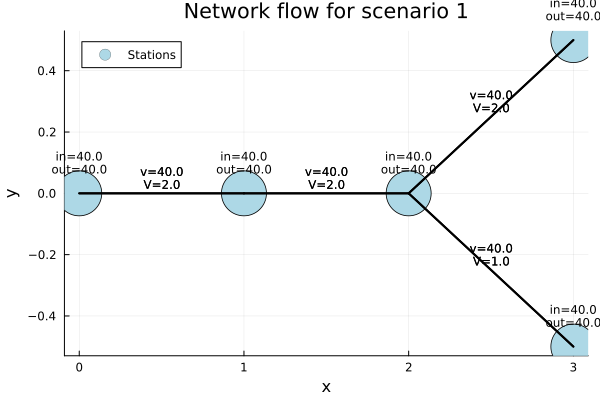

In [11]:
using Plots
using Statistics

# pick a scenario to visualize
s = 1

# compute total flow over each edge (sum over lines, trains, and OD pairs)
edge_flow = Dict()
for (i,j) in E
    edge_flow[(i,j)] = sum(value(v[s,l,k,(i,j),o,d]) for l in L, k in K, o in M, d in M)
end

# compute total train assignments per edge
V_flow = Dict()
for (i,j) in E
    V_flow[(i,j)] = sum(value(V[s,l,k]) for l in L, k in K if B[l,i,j] == 1)
end
# print the assigned line to each vehicle k, or print none if no line assigned
for k in K
    assigned_line = nothing
    for l in L
        if value(V[s,l,k]) > 0.5
            assigned_line = l
            break
        end
    end
    if assigned_line != nothing
        println("Train $k assigned to line $assigned_line")
    else
        println("Train $k not assigned to any line")
    end
end

# compute total entries/exits per station from v
# CORRECTED: 
# - Exits (boarding/departing) = flow where station i is the ORIGIN (o == i)
# - Entries (alighting/arriving) = flow where station i is the DESTINATION (d == i)
station_exits = Dict()    # people boarding at station i (origin)
station_entries = Dict()  # people alighting at station i (destination)


for i in M
    # Exits: sum of demand originating at i (count each OD pair once)
    station_exits[i] = sum(D[s,i,d] + sum(deltaD[s,i,d,n]*value(x[n]) for n in N) 
                          for d in M if d != i)
    
    # Entries: sum of demand destined for i (count each OD pair once)
    station_entries[i] = sum(D[s,o,i] + sum(deltaD[s,o,i,n]*value(x[n]) for n in N) 
                            for o in M if o != i)
end

# Node positions (just for a simple layout)
pos = Dict(
    1 => (0,0),
    2 => (1,0),
    3 => (2,0),
    4 => (3,0.5),
    5 => (3,-0.5)
)

# plot nodes
scatter([pos[i][1] for i in M], [pos[i][2] for i in M],
    marker=:circle, markersize=25, c=:lightblue,
    label="Stations")

# annotate nodes with total entries/exits
for i in M
    annotate!(pos[i][1], pos[i][2]+0.1,
        text("in=$(round(station_entries[i], digits=1))\nout=$(round(station_exits[i], digits=1))", :center, 8))
end

# plot edges with flow labels
for (i,j) in E
    x = [pos[i][1], pos[j][1]]
    y = [pos[i][2], pos[j][2]]
    plot!(x, y, lw=2, color=:black, label=false)
    midx = mean(x)
    midy = mean(y)
    annotate!(midx, midy+0.05,
        text("v=$(round(edge_flow[(i,j)],digits=1))\nV=$(V_flow[(i,j)])", 8))
end

#print the value of the crowding metric z
println("Crowding metric z = ", value(z))

title!("Network flow for scenario $s")
xlabel!("x")
ylabel!("y")